In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.utils.fixes import loguniform

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'synth', 'synth_alfa_svm_db.csv'))
print(df.shape)
print(df.columns)

(1350, 38)
Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base'],
      dtype='object')


In [5]:
COLS_CM = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
print(len(COLS_CM))

COL_Y = 'Test.Poison'
DIF_LEVELS = ['Hard', 'Normal', 'Easy']

28


In [6]:
N_ITER_SEARCH = 200
N_FOLD = 5

In [7]:
def get_pivot_table(df, q=0.95):
    # Step 0: Add difficulty levels
    df = df.copy()
    df['Difficulty'] = df['Data.Base'].apply(lambda x: x.split('_')[0])
    cat_type = CategoricalDtype(categories=DIF_LEVELS, ordered=True)
    df['Difficulty'] = df['Difficulty'].astype(cat_type)

    # Step 1: Find parameter
    param = {'alpha': loguniform(1e-4, 10),}
    X = df[COLS_CM]
    y = df[COL_Y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alpha = np.round(best_estimator_['alpha'], 4)
    print(f'alpha={alpha:.6f}')

    # Step 2: Estimate
    df['Prediction'] = 0.

    # Split by clean data
    idx_clean = df[df['Rate'] == 0].index
    kf = KFold(n_splits=N_FOLD, shuffle=True)
    for i_train, i_test in kf.split(idx_clean):
        idx_train_clean = idx_clean[i_train]
        idx_test_clean = idx_clean[i_test]

        data_train = df.loc[idx_train_clean, 'Data.Base']
        data_test = df.loc[idx_test_clean, 'Data.Base']

        idx_train = df[df['Data.Base'].isin(data_train)].index
        idx_test = df[df['Data.Base'].isin(data_test)].index
        assert len(idx_train) + len(idx_test) == df.shape[0], f'{len(idx_train)} + {len(idx_test)} != {df.shape[0]}'

        X_train = df.loc[idx_train, COLS_CM]
        y_train = df.loc[idx_train, COL_Y]
        X_test = df.loc[idx_test, COLS_CM]

        regressor = linear_model.Ridge(alpha=alpha)
        regressor.fit(X_train, y_train)

        df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)

    # Apply clipping
    df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

    # Step 3: Find threshold
    # y_true_ = (df['Rate'] > positive_threshold).astype(int)
    # y_score_ = df['Train.Poison'] - df['Prediction']
    # fpr, tpr, thresholds = roc_curve(y_true_, y_score_)
    # idx_t = np.argmax(np.sqrt((1 - fpr)**2 + tpr**2))
    # threshold = thresholds[idx_t]

    # df_ = df[(df['Difficulty'] != 'Hard') & (df['Rate'] == 0)]
    df_ = df[(df['Difficulty'] == 'Normal') & (df['Rate'] == 0)]
    # df_ = df[df['Rate'] == 0]
    dif_00 = (df_['Train.Poison'] - df_['Prediction'])
    threshold = np.quantile(dif_00, q)

    print(f'threshold: {threshold}')

    # Step 4: Populate pivot table
    results = (df['Train.Poison'] - df['Prediction']) >= threshold
    df_ = df[['Difficulty', 'Rate']].copy()
    df_['Prediction'] = results.astype(int)
    df_ = df_.rename(columns = {'Difficulty':'Dataset Difficulty', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Dataset Difficulty', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Dataset Difficulty', 'FPR')
    df_pivot = df_pivot[['Easy', 'Normal', 'Hard']]
    df_pivot
    return df_pivot, threshold

In [8]:
def get_pivot_noise(df, train_noise_lvl=0, q=0.95):
    # Read noise rate from data's name
    noise_rate = df['Data'].apply(lambda x: float(x.split('_')[6][2:]))
    df['Noise.Rate'] = noise_rate

    # Remove noise rate from data's name
    df['Data.Base'] = df['Data.Base'].apply(lambda x: '_'.join(list(np.delete(x.split('_'), -2))))

    # Step 1: Find parameter
    param = {'alpha': loguniform(1e-4, 10),}
    X = df[COLS_CM]
    y = df[COL_Y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alpha = np.round(best_estimator_['alpha'], 4)
    print(f'alpha={alpha:.6f}')

    # Step 2: Estimate
    df['Prediction'] = 0.

    # Split by clean data
    idx_clean = df[(df['Rate'] == 0) & (df['Noise.Rate'] == 0)].index
    kf = KFold(n_splits=N_FOLD, shuffle=True)
    counter = 0
    for i_train, i_test in kf.split(idx_clean):
        idx_train_clean = idx_clean[i_train]
        idx_test_clean = idx_clean[i_test]

        data_train = df.loc[idx_train_clean, 'Data.Base']
        data_test = df.loc[idx_test_clean, 'Data.Base']

        df_noise_threshold = df[df['Noise.Rate'] <= train_noise_lvl]
        idx_train = df_noise_threshold[df_noise_threshold['Data.Base'].isin(data_train)].index

        idx_test = df[df['Data.Base'].isin(data_test)].index
        counter += len(idx_test)

        X_train = df.loc[idx_train, COLS_CM]
        y_train = df.loc[idx_train, COL_Y]
        X_test = df.loc[idx_test, COLS_CM]

        regressor = linear_model.Ridge(alpha=alpha)
        regressor.fit(X_train, y_train)

        df.loc[idx_test, 'Prediction'] = regressor.predict(X_test)
    assert counter == df.shape[0], f'{counter} != {df.shape[0]}'

    # Apply clipping
    df['Prediction'] = np.amin([df['Prediction'].to_numpy(), np.ones(df.shape[0])], axis=0)

    # Set Threshold
    df_ = df[(df['Rate'] == 0) & (df['Noise.Rate'] <=train_noise_lvl)]
    dif_00 = (df_['Train.Poison'] - df_['Prediction'])
    threshold = np.quantile(dif_00, q=q)
    print(f'threshold: {threshold}')

    results = (df['Train.Poison'] - df['Prediction']) > threshold
    df_ = df[['Noise.Rate', 'Rate']].copy()
    df_['Prediction'] = results.astype(int)
    df_ = df_.rename(columns = {'Noise.Rate':'Noise Label Rate', 'Rate':'Poisoning Rate', 'Prediction': 'FPR'})
    df_grouped = df_.groupby(['Noise Label Rate', 'Poisoning Rate']).sum()
    df_grouped = df_grouped.reset_index()
    df_pivot = df_grouped.pivot('Poisoning Rate', 'Noise Label Rate', 'FPR')
    return df_pivot

In [9]:
pivot_tables = []

for workspace in [f'diva_{i:02d}' for i in range(1, 4)]:
    print(workspace)

    for att in ['falfa_nn', 'alfa_svm']:
        df_ = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', 'synth', f'synth_{att}_db.csv'))

        tab, _ = get_pivot_table(df_,  q=0.98)
        tab.to_csv(os.path.join(path_output, f'synth_pivot_{workspace}_{att}.csv'))

        tab = tab.reset_index()
        pivot_tables.append(tab)
        
pivot_1 = pd.concat(pivot_tables, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_1 = pivot_1 * 2

diva_01
alpha=0.000100
threshold: 0.35075161832031215
alpha=0.016400
threshold: 0.30978340887544287
diva_02
alpha=0.053500
threshold: 0.37023457979995195
alpha=0.000400
threshold: 0.3307596962345066
diva_03
alpha=0.080600
threshold: 0.341502698769963
alpha=0.011400
threshold: 0.3218473415007165


In [10]:
attacks = [['falfa_nn', 'alfa_svm'], ['falfa_nn'], ['falfa_nn']]

pivot_tables_noise = []
for i, workspace in enumerate([f'diva_{i:02d}' for i in range(1, 4)]):
    for att in attacks[i]:
        path_data = os.path.join(PATH_ROOT.parent, workspace, 'results', 'synth_noisy', f'synth_{att}_db.csv')
        print(path_data)

        df_ = pd.read_csv(path_data)
        tab = get_pivot_noise(df_, q=0.98)
        path_pivot_table = os.path.join(path_output, f'synth_noise_pivot_{workspace}_{att}.csv')
        print(f'Save to: {path_pivot_table}')
        tab.to_csv(path_pivot_table)

        tab = tab.reset_index()
        pivot_tables_noise.append(tab)

pivot_2 = pd.concat(pivot_tables_noise, ignore_index=True).groupby('Poisoning Rate').mean().round()
pivot_2 = pivot_2 * 2

/home/lukec/workspace/diva_01/results/synth_noisy/synth_falfa_nn_db.csv
alpha=0.007600
threshold: 0.35386143809933185
Save to: /home/lukec/workspace/diva_01/results_plot/synth_noise_pivot_diva_01_falfa_nn.csv
/home/lukec/workspace/diva_01/results/synth_noisy/synth_alfa_svm_db.csv
alpha=0.082000
threshold: 0.35142103049077117
Save to: /home/lukec/workspace/diva_01/results_plot/synth_noise_pivot_diva_01_alfa_svm.csv
/home/lukec/workspace/diva_02/results/synth_noisy/synth_falfa_nn_db.csv
alpha=0.003100
threshold: 0.3228301751339651
Save to: /home/lukec/workspace/diva_01/results_plot/synth_noise_pivot_diva_02_falfa_nn.csv
/home/lukec/workspace/diva_03/results/synth_noisy/synth_falfa_nn_db.csv
alpha=0.002000
threshold: 0.33828002461587414
Save to: /home/lukec/workspace/diva_01/results_plot/synth_noise_pivot_diva_03_falfa_nn.csv


Save to: /home/lukec/workspace/diva_01/results_plot/synth_heatmap.svg


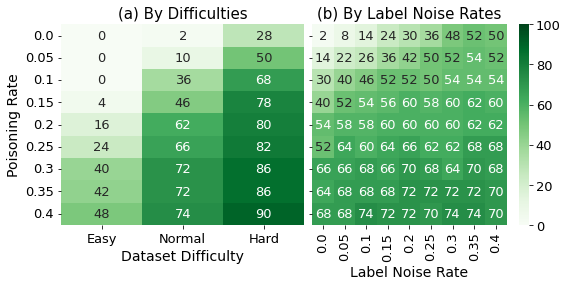

In [11]:
FONTSIZE = 13
FIGSIZE = (8, 4)
X_LABELS = ['Dataset Difficulty', 'Label Noise Rate']
TITLES = ['(a) By Difficulties', '(b) By Label Noise Rates']

plt.rcParams["font.size"] = FONTSIZE
fig, axes = plt.subplots(1, 2, sharey=True, figsize=FIGSIZE)

sns.heatmap(pivot_1, ax=axes[0], annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=100, cbar=False)
axes[0].set_ylabel('Poisoning Rate', fontsize=FONTSIZE+1)

sns.heatmap(pivot_2, ax=axes[1], annot=True, fmt='.0f', cmap="Greens", vmin=0, vmax=100)
axes[1].set_ylabel('')

for i, ax in enumerate(axes):
    ax.set_xlabel(X_LABELS[i], fontsize=FONTSIZE+1)
    ax.set_title(TITLES[i], fontsize=FONTSIZE+2)

plt.tight_layout(pad=0.6)
plot_heatmap = os.path.join(path_output, 'synth_heatmap.svg')
plt.savefig(plot_heatmap, dpi=300)
print(f'Save to: {plot_heatmap}')